# Car Recognition with Deep Learning

This tutorial shows how Deep Neural Networks are used to recognize cars on images versus images with no cars on them (binary classification).

In [9]:
import os
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=' + device + ',floatX=float32,nvcc.flags=-D_FORCE_INLINES'

import argparse
import csv
import datetime
import glob
import math
import sys
import time

import numpy as np

import pandas as pd # Pandas for easier Data handling in preparation

from sklearn import preprocessing
from sklearn.cross_validation import ShuffleSplit, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

from theano import config
from theano import function as tfunction

import keras
from keras.optimizers import SGD, RMSprop, Adagrad

from PIL import Image

In [5]:
from progressbar import ProgressBar
# needed?
from keras.preprocessing import image
from keras.callbacks import Callback, History, EarlyStopping, ModelCheckpoint # BaseLogger,

import json
#import cPickle # for saving scaler and labelencoder

In [3]:

RANDOM_SEED = 2107


## Load the Images from Training Set

In [3]:
path = 'data/CarData/TrainImages'
files = glob.glob(os.path.join(path, '*.pgm'))
print "Found", len(files), "files"

Found 1050 files


In [33]:
images = []
image_names = []

for filename in files:
    image_names.append(os.path.basename(filename))
    #img = Image.open(filename)
    with Image.open(filename) as img:
        images.append(np.array(img))

neg-85.pgm


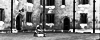

In [36]:
i=0
print image_names[i]
Image.fromarray(images[i])

In [45]:
type(images[i])

numpy.ndarray

In [46]:
images[i].shape   # height x width

(40, 100)

Note: Color RGB images have an additional dimension of depth 3, e.g. (40, 100, 3)

## Make 1 big array of list of images

In [44]:
img_array = np.array(images)
img_array.shape

(1050, 40, 100)

## Create the Groundtruth based on filenames:

In [37]:
classes = []
for name in image_names:
    if name.startswith('neg'):
        classes.append(0)
    else:
        classes.append(1)

In [47]:
classes

[0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,


In [4]:

# STANDARDIZE DATA

def standardize(data, return_scaler = True, copy=True):
    '''standardize the data with zero mean unit variance (feature attribute-wise)

    data: numpy array to be transformed
    return_scaler: if True, a tuple of (data, scaler) will be returned with the scaler object containing all necessary parameters to scale other data again
    copy = False means try to avoid a copy and do inplace scaling instead.
    '''

    if return_scaler:
        # STANDARDIZATION (0 mean, unit var)
        scaler = preprocessing.StandardScaler(copy)
        # alternative: NORMALIZATION (min - max Normalization to (0,1))
        #scaler = preprocessing.MinMaxScaler()
        data = scaler.fit_transform(data)
        return (data, scaler)
    else:
        return preprocessing.scale(data,axis=0,copy=copy)
        # axis=0 means independently standardize each feature, otherwise (if 1) standardize each sample

    # how to get scaler parameters:
    #print scaler.mean_
    #print scaler.scale_


def standardize_flat(data):
    from scipy.stats.mstats import zscore
    return zscore(data,axis=None)
    # the manual version:
    #m = np.mean(a)
    #s = np.std(a)
    #(a - m) / s



In [40]:
print "Groundtruth Statistics:"
#class_counts = 
for v in set(classes):
    print "Class", v, ":", classes.count(v)

Groundtruth Statistics:
Class 0 : 500
Class 1 : 550


In [5]:
    folds = 3

In [43]:
baseline = 550 * 1.0 / len(classes)
baseline

0.5238095238095238

In [57]:
    # reorder data

    # color channel is the last axis in input images, we move it to axis 1
    # TODO check if this doesnt rotate the image - i think it does
    images = np.swapaxes(images,1,3)
    images.shape

(7833, 3, 224, 224)

In [58]:
    # TODO why is this done (e.g. in ResNet 50)
    # TODO this depends on Theano vs Keras: change Code above to incorporate K.image_dim_ordering()
    images = reorder_RGB(images, dim_ordering='default') 
    images.shape

(7833, 3, 224, 224)

In [59]:
images.min(), images.max()

(0, 255)

In [61]:
images = images.astype(config.floatX)

In [62]:
# standardize each RGB channel - inspired from keras ResNet50 / image_util preprocess

x = images

for c in range(3):
    print x[:, c, :, :].mean()
    x[:, c, :, :] -= x[:, c, :, :].mean()
    x[:, c, :, :] /= x[:, c, :, :].std() # was not in ResNet implementation

images = x

186.14
188.196
194.957


In [63]:
images.min(), images.max()

(-2.5346594, 0.86231875)

In [50]:
    # standardize FLAT
    # TODO verify which kind of standardization we need
    # TODO verify if the data order is right for this standardization
    # TODO also check whether we need to standardize each channel separately
    images = standardize_flat(images)
    images.dtype

MemoryError: 

In [17]:
# standardize flat myself
images -= np.mean(images, axis=0) # 0 center
images /= np.std(images, axis=0)  # normalize by stdev


In [18]:
images.min(), images.max()

(-279.01828, 41.362053)

In [64]:
images.mean()

7.7521609e-06

In [65]:
    # create folds
    splits = StratifiedKFold(groundtruth, n_folds=folds, shuffle=True, random_state=RANDOM_SEED)


In [66]:
    for train_ind, test_ind in splits:
        print "Train:", len(train_ind), "Test:", len(test_ind)


Train: 5221 Test: 2612
Train: 5222 Test: 2611
Train: 5223 Test: 2610


In [113]:
train_img = images[train_ind]
test_img = images[test_ind]

In [68]:
train_gt = groundtruth[train_ind]
test_gt = groundtruth[test_ind]

In [18]:
train_gt.shape

(5223,)

In [19]:
train_img.shape

(5223, 3, 224, 224)

In [26]:
train_img.dtype

dtype('float32')

In [27]:
train_gt.dtype

dtype('int64')

In [115]:
input_shape = images.shape[1:]
output_units = 1

multi_class = output_units > 1
multi_class

False

In [70]:
# Keras 0.3
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten # Reshape,
from keras.layers.convolutional import Convolution2D, MaxPooling2D # CNN
from keras.optimizers import SGD

In [ ]:
# Keras 1.x
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD

In [83]:
# taking just one channel for full model
imagesch1 = images[:,0,:,:]

In [91]:
images_flat = images.reshape(images.shape[0],-1)

In [92]:
train_img = images_flat[train_ind]
test_img = images_flat[test_ind]


In [95]:
input_shape = (images_flat.shape[1])

In [107]:
# simple Full network
model = Sequential()

model.add(Dense(256, input_dim=input_shape))
model.add(Dense(256))
model.add(Dense(1,activation='sigmoid'))



In [117]:
# simple CNN to test

model = Sequential()
# input: 100x100 images with 3 channels -> input_shape should be (3, 100, 100) 
# this applies 32 convolution filters of size 3x3 each.
model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=input_shape))
#model.add(Activation('relu')) # WAS COMMENTED OUT WHEN WORKED
#model.add(MaxPooling2D(pool_size=(2, 2))) # NEW
#model.add(Dropout(0.1)) # NEW

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
# Note: Keras does automatic shape inference.
model.add(Dense(256))
#model.add(Activation('relu'))
model.add(Dropout(0.1))

if output_units > 1:
    model.add(Dense(output_units))
    model.add(Activation('softmax'))
else:
    model.add(Dense(1,activation='sigmoid'))


In [124]:
# VGG-like convnet:
# (from https://keras.io/getting-started/sequential-model-guide/)

model = Sequential()
# input: 100x100 images with 3 channels -> input_shape should be (3, 100, 100) 
# this applies 32 convolution filters of size 3x3 each.
model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# Note: Keras does automatic shape inference.
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

if output_units > 1:
    model.add(Dense(output_units))
    model.add(Activation('softmax'))
else:
    model.add(Dense(1,activation='sigmoid'))


In [125]:
model.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 3, 224, 224)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Convolution2D (Unnamed)       (None, 32, 222, 222)          896                 
Activation (Unnamed)          (None, 32, 222, 222)          0                   
Convolution2D (Unnamed)       (None, 32, 220, 220)          9248                
Activation (Unnamed)          (None, 32, 220, 220)          0                   
MaxPooling2D (Unnamed)        (None, 32, 110, 110)          0                   
Dropout (Unnamed)             (None, 32, 110, 110)          0                   
Convolution2D (Unnamed)       (None, 64, 108, 108)          18496               
Activation (Unnamed)          (None, 64, 108, 108)          0       

In [119]:
# we use test data as validation data to see direct results (usually not recommended)
validation_data = (test_img, test_gt)

In [128]:
if multi_class:
    loss = 'categorical_crossentropy' # multi class
    class_mode='categorical'
    #optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # try simpler first
    optimizer = SGD(lr=0.001)
else: # binary 0/1
    loss = 'binary_crossentropy' 
    class_mode='binary'
    optimizer = 'rmsprop'
    #optimizer = RMSprop(lr=0.0001)
    #optimizer = 'adam'
    #optimizer = SGD(lr=0.001)

print "Class mode:", class_mode, ", multi_class:", multi_class
    

Class mode: binary , multi_class: False


In [129]:

model.compile(loss=loss, optimizer=optimizer, class_mode=class_mode)
    

In [ ]:
    epochs = 5
    model.fit(train_img, train_gt, batch_size=32, nb_epoch=epochs, validation_data=validation_data, show_accuracy=True)

Train on 5223 samples, validate on 2610 samples
Epoch 1/5
5223/5223 [==============================] - 49s - loss: 2.9302 - acc: 0.7551 - val_loss: 1.3788 - val_acc: 0.7360
Epoch 2/5
5223/5223 [==============================] - 52s - loss: 0.3937 - acc: 0.8878 - val_loss: 0.2455 - val_acc: 0.9330
Epoch 3/5
5223/5223 [==============================] - 52s - loss: 0.2262 - acc: 0.9349 - val_loss: 0.2068 - val_acc: 0.9138
Epoch 4/5
3168/5223 [=================>............] - ETA: 18s - loss: 0.1428 - acc: 0.9602

In [77]:
# verify Accuracy on Train set
train_pred = model.predict_classes(train_img)
accuracy_score(train_gt, train_pred)

5223/5223 [==============================] - 8s     


0.72372199885123489

In [78]:
# TESTING
test_pred = model.predict_classes(test_img)
acc = accuracy_score(test_gt, test_pred)
acc

2610/2610 [==============================] - 4s     


0.72375478927203063